
<hr style="height:2px" > 

# Keggle Cats vs Dogs 학습

이번에는 보다 실용적인 데이터로 Keggle 에서 제공하는 데이터를 이용한 학습을 알아보겠다. keggle 은 이미지 인식 경연용 데이터를 제공하는데 대표적으로 개와 고양이의 이미지를 모아서 비교하는 데이터가 있다. 

    https://www.kaggle.com/c/dogs-vs-cats/data 

원본은 다음에 있지만 가입뿐만 아니라 전화번호까지 요구하므로 업로드된 어제자 따끈따근한 데이터를 쓰기로 하자.  

<a href = 'https://drive.google.com/open?id=1pHZTvYsSfanqrUESu3r7qZzaeziaHFuo' >  download  </a>


다운로드 받은 이미지 파일을 풀면 train, test1 두가지 압축 파일이 보일 것이다. test1 은 테스트용 이미지인데 레이블링이 되어있지 안아 쓰기 불편하니 일단 train만 사용해 학습과 검증을 하도록 하겠다. 


## 데이터 제너레이터 

train 파일을 풀어보면 모든 이미지가 dog.1.jpg, dog.2.jpg ..  , cat.1.jpg, cat.2.jpg, .. 이런식으로 다루기 편하게 네이밍 되어있는 것을 볼 수 있다. 이런 파일들을 다룰때는 직접 읽어들여서 이것을 넘피 배열로 바꿔주는 것보다 keras 의 ImageDataGenerator 를 사용하면 편하다. 데이터 제너레이터는 디렉토리상의 파일들을 읽어서 자동으로 numpy 형식의 입력데이터로 변환해 줄 뿐만 아니라 데이터의 변조생성까지 지원하므로 이미지 학습시에는 필수에 가깝다. 

ImageDataGenerator 는 이미지 데이터 처리시 이미지를 디렉토리별로 클래스를 구분하는데 위의 예제의 경우 이미지를 train/dog, train/cat 으로 구분해주어야 한다. validation 까지 생각해서 디렉토리를 다음과 같이 구성해보자. 전체 학습은 시간이 오래걸리므로 1/10 정도의 데이터로 구성하는 것을 추천한다. 일단 본인인은 train : 2500 , test: 250 로 구성했 진행하도록 하겠다. 

    train_s
        dog
        cat 
    test_s
        dog
        cat


이제 데이터 제네레이터를 정의해보도록 하겠다. 이미지 사이즈는 속도까지 고려해 150x150 으로 정규화한다. 

In [1]:
from keras.preprocessing.image import ImageDataGenerator 

trdg = ImageDataGenerator(rescale = 1./255 )
ttdg = ImageDataGenerator(rescale = 1./255 )

train_gen = trdg.flow_from_directory( 
    "dnc/train_s",
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary') 

val_gen = ttdg.flow_from_directory(
    "dnc/test_s",
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary') 


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

Found 2500 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


이들을 수동으로 데이터를 얻어낼 경우 다음과 같이 for 문을 사용할 수 있다. 

In [ ]:
for data_batch, labels_batch in train_gen:
    print(data_batch.shape, labels_batch.shape)
    break

In [10]:
from keras import layers 
from keras import models
import keras

keras.backend.clear_session()
model = models.Sequential() 
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2))) 

model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['acc'] )

## 학습 
    
다음은 데이터 제네레이터를 사용해 학습을 하는 방법이다. 이를 돌려보고 직접 시각화하며 그 결과를 살펴보자. fit을 사용하는 일반적인 학습과 달리 generator 를 통합 학습은 fit_generator 라는 메소드를 사용한다. 기본적으로는 input_data, valdation_data 에 데이터 대신 제네레이터를 입력하는 점이 다르다. 그리고 generator 에 이미 batch_size 가 지정되어 있기 때문에 이를 사용하지 안고 대신 steps_per_epoch 라는 파라미터가 사용되는데 이는 한 epoch 를 30회의 배치로 나누어 처리한다는 의미로 이해하면 된다. 


In [13]:
history = model.fit_generator(train_gen, steps_per_epoch = 100,  epochs = 30, validation_data = val_gen, validation_steps = 50).history
#history = model.fit_generator(train_gen, steps_per_epoch = 100,  epochs = 30).history

Epoch 1/30
100/100 [==============================] - 6s 60ms/step - loss: 0.0554 - acc: 0.9865 - val_loss: 1.9113 - val_acc: 0.7688
Epoch 2/30
100/100 [==============================] - 6s 64ms/step - loss: 0.0547 - acc: 0.9835 - val_loss: 1.4033 - val_acc: 0.8146
Epoch 3/30
100/100 [==============================] - 7s 69ms/step - loss: 0.0533 - acc: 0.9820 - val_loss: 1.1064 - val_acc: 0.8198
Epoch 4/30
100/100 [==============================] - 6s 58ms/step - loss: 0.0735 - acc: 0.9835 - val_loss: 1.0862 - val_acc: 0.8165
Epoch 5/30
100/100 [==============================] - 6s 58ms/step - loss: 0.0348 - acc: 0.9915 - val_loss: 1.5998 - val_acc: 0.8156
Epoch 6/30
100/100 [==============================] - 7s 72ms/step - loss: 0.0484 - acc: 0.9890 - val_loss: 1.3769 - val_acc: 0.7979
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.0375 - acc: 0.9905 - val_loss: 1.4076 - val_acc: 0.8073
Epoch 8/30
100/100 [==============================] - 6s 63ms/step - 

이제 학습 결과를 도식화해보자. 

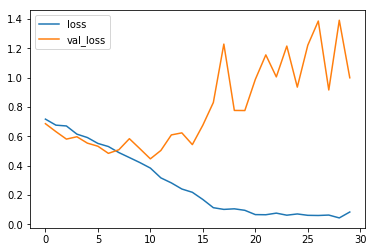

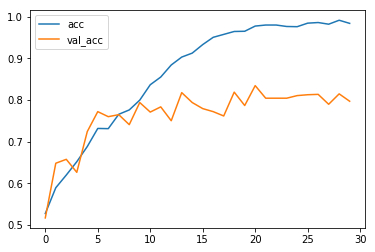

In [12]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label = 'loss')            
plt.plot(history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history['acc'], label = 'acc')            
plt.plot(history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

#print("last acc / val_acc : ", history['acc'][-1], "/",  history['val_acc'][-1])

### <font color = 'red'> 연습문제 5-1 : 네트워크 변형 비교
    
위의 cnn 구조를 변화시켜가며 학습성능의 변화를 테스트해보자. 

아마 실제 적중률은 80% 정도에서 그 이후에는 과적합 상태로 흐르는 것을 볼 수 있을것이다.  더 세세한 설정과 전체 데이터를 기준으로 처리하면 더 높은 적중률을 얻을 수 있겠지만 일단은 이정도로 만족하자. 

## 실제 이미지 예측에 적용

이번에는 학습된 데이터를 실제 예측에 사용해 보도록 하자. 이를 위해 test1의 이미지 하나를 선택하도록 하겠다. 

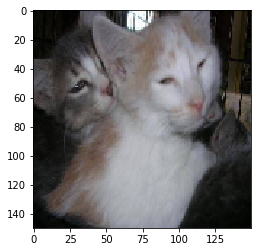

In [7]:
from keras.preprocessing import image
import numpy as np 

img = image.load_img('dnc/test1/16.jpg', target_size = (150,150))
plt.imshow(img)
x = image.img_to_array(img)[np.newaxis,:,:,:]


(150,150,3)인 3차원 배열인 x 를 (1,150,150,3) 로 만들기 위해 [np.newaxis, :, :, :] 를 사용한 점에 유의하자. 

이제 x 를 예측하는 방법은 다음과 같다. 위의 경우 결과값이 Dense(1) 로 하나의 출력을 갖게 했는데 이때는 0과 1로 각 클래스가 결정된다. 직접 실험 결과 고양이는 0, 개는 1로 표현되었다. 이를 통해 위의 이미지를 예측하는 코드를 작성하면 다음과 같다. 

In [8]:
if  model.predict(x) > 0.5 :
    print("dog")
else :
    print("cat")

cat


test1 디렉토리의 내용이 아니라 직접 인터넷에서 검색한 이미지를 사용할 수도 있다. 다음의 코드를 이용해 웹으로부터 검색한 이미지의 url을 이용해 파일을 읽어들일 수 있다. 

cat


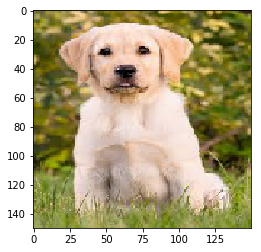

In [19]:
from urllib.request import urlopen
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMVFhUWGBgYFxgYGBgXGBUYGhcYFxoXHRcYHSggGBolGxgWITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0mICYtLS0yLS0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAQMAwgMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAAIHAQj/xABDEAABAwIEAwUGBAQDBgcAAAABAAIRAwQFEiExQVFhBiJxgZETMqGxwfAHFELRI1Ji4XKC8TNTkqKywhUWJDRDc6P/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMEAAX/xAAtEQACAgICAQQBAgUFAAAAAAAAAQIRAyESMVEEEyJBYTJxFEKBwfAVM1Jysf/aAAwDAQACEQMRAD8ACr4e7KXwp7F7QyHLR1/ULzTLdJ+CnxG3a1sgQV4cppy4P9yyf2gq3sqT2mAsr2lMNAy7JRY35YFcMHNOowPckgpWyipnuB/l3DI5kHwW2MdmKZGekcp3029ERVxK3pydEMzHPa91jTqqKUl0UqPTFN9eVDTDIkjRVW8qVGuJLDE7xor1dn2EOc3NKUY1iLajYa3hv/ZBuLSsRx/IjpXmcieCx144GNY4Ly1EmMspr+Wloaxhc7gACT8Fmkql8ToptbNbaXNly1uajYg6FeU6VxTd36NQDeMp22U9zRztlzC076iEZqndMp2hfVpuDZYM0BJqlxVD2vcDDTMJxYXjqVSCJaefBMMTyjvFkg7qqyqtEnG/sIp/iA1tMBrTMJM/tRUqOJOngo7u2p1G/wANu3RLXWLh4KL4SA5z+2NrLtM9jjxBTezvhVDtYPxVds7BsZihrmuWHuyFTC4yfCIG3HbJMRYc5bmJPzTfs1i7KVFzKpgid+STYa01Kg4klW227JMqu/iBW9RFKlJHY+V2hDh/bAsY9pk6nL57JWMfqx3pIVsrfhy3PLHkDkg8ZwQW47w05qUVjfR2RZEhPbmhWbEQfDil172cIMs1BRjcjDLSmtpdEhP7mTE7j14IRkIR2RqLFaRiD1iX/UJ+ClhlN+Y5w3ZDU6jrglpbEIC0xd7Tl06py3F20R3RJK6GFrodST7PBgWVpKSVcTdTOQHSU2qdqS4e7EpFc02vdmVMeJJ7On18Q8OD2ZtzGye9jK0k+0ERoEDgtk3KCTCttrgTDBdI+qeO04R3/b+pWEaqUiarYG6MAhrB+reTyhAf+QCahmsMh/p737K12zA0Q2GgfBSMuJmNv24rUsGNJWrYrtgWF9lragO6yTxLjmnrGwTWnRa0aAN8BCjDiSvKtRV0ukcosKLdFHUoteCHgEHgROiibVJhbP1R5A4iq47L2jv/AIgOoJBUd/2ZoupZKYDTGhMn1ndNnSQo6NXh8FN48b04oKT+jm9eyqWoc11F0To4DunrKT3dXNGmi7FUcCIOo4qsX3ZCjUzGm5zHHUcWz4cB4LJP0q/kG3RQxaGJGyixegxzBlGqe3FpVt3eyrNEEHK4HuujkgsPy1KxpjWFj3jlbVE3G9Fdwyo6k4PDSQ3orNhfawVKwae6Dx6ovE8OLNCO6eOyWXPZqg1mdru8Nd1b3I5Vs7jKHQ+7R4vUtmio10jkg6+MNvKBa5uscVSa1++pUDKj5YDp1Vgs8Qp09o0U/Y47D7t/sUq9sX0yRqNdEfgt04d1yZ45iTKxENhRWlJkEka8Fb3VXGRHjvQSaxWJQ66dPFYl9t+DuR5QuRO+qKqvKRUWHNKcU3yFRuUXcRYu0SHWAm2C4PUruytERuTsBzSawou9o3iSQAOfRdWoMFuxrAdSRmPMnT05I405St9F4Qsnw7CqNu0aZ3j9bhx6DZqNtrjNLp6JXfVTBUtge61vGJ9Vp5eDSoJIY165yho3d5QPH1TK0oZW9UjtjnuAAe6OHXx8PmjO0PaOhaN/iva0bAcXHkGjVx6CSVWPWycu9Dak4Tvrx6Lys7dUDAO2FO5rFlPO39QD2lsjaRIEg6H1Vx9tPolba00cop7TJqL4EdVLXuQ06oCi0kSkPa/GBbUzVgvcBo2dyl5P6H4q9lzpOBEhL8TYWEVBts76FUbs/wDiO4ZPzdH2IqOyte17HgHTRzQczNwJLYPNdGrtFRhHBwTyWqfZOLp2ugP2uqhdVhyGw+rnZH6mGDx2JBUtwJ15cFllJmpRVhNUMeyKjWubycA4ehVGxfAhZ3LLqlPsXnK9v+7J2/yn4K5z3UL2jps/KVGv4gR0MyCjJ840/BDJBLZVO2OPsNLK3UuEaLmNe7rBuVxcBwlXbCbdvtQ6pqB8FaK+HW1aCWggegWbE1FEJRc92cVc4zJRNG5jiusYvgVo6kYDZjouWVsG75E92dFdSjIjLG4h1pVbUGQCSp7q1qs0I0Knw3D20m5mmTvupDd1KhAfEA8FHJBw2hovX5FUOWK0ihR6fBYu/iJDcWVbFMLdROqFbcQFb+3ddheGCJVVp2clMppLYrhT0MLCpFWk/WGuaT5GV0y/AcMzTLe64eq51YsGUg7q09lsSBaaL+E5eoO4VMMtF8bp/uPrzWOuqlsd3ngBHyCHqVJHUaffkirNsUz98VVGhi7CcZb+ZqN17jsp04kafT1VU/ELsveXVd1djhDdGCYyjQk6CZJ+QTjC2Re3HVzHf8jR9PirvQ7wylXVqRGVOJyHsj2cu6dwKlVzi4AkS5xPCR3tp8vJdltKctUX5VoPz8OSm9rBCWTblsaKSjSNqFAgRKqHbfAX126QehmCDoZg8ldJ4ryo2Qka8DJ+Tj2C/hW7PNRwynhGv7T/AH8V1zDrY0qbKcyGtA16CEXbtESApQNCnl8q2TTS0kVTs5VPta7T+mq9vTUNf8yU1riClOCf+5uf/tJ//NgTu5Ys8lo0J7IqbZEKv9u7zuimD1P0H3zR2IX4pNL3GAPmdgqzUpPuQ5/EqDyapE83gQ0qkbpvg9/SnK4jXZJadPJUIfzW+KUWvgt4QoqT5U0ZU6LBiOFiczScvKdFWL/BQSSHHyKf2WIDJkJnTRV29l73NbtJStyTDJL6AbEauZm2W1G+DSWoYYXUa+ZKJurGAOau0qoi5eCXzWLZjBAnksXfw8P+QfkA0bKq/wDiPMlSUKRGpR1OrDNfRJn3hkjgl4TnJr6HtJWNDeNG3mpad1lcHt3GqVMajbRw2I058lfHiUNWDnZdMIxNlUaESIkcuEqy0md0jmPp+65dZ0yyq19Pn5Qdx1XTalwABPRV6NWOTkqfZWKLmtvKhLtS1kDXXgT8FcqF0AA7hCoON0S2q2vBykubPn+8qz4Yc9IDhwPQ6/NUctaOS3sdVa/dnnquddrO2+TSlcMbvDR75iO8dO6DPjoeUm91wA2D/LC4T217PinVc/No50cIJjbptx4quCK+xM0mlobUu2tZx1uQ3xcR8dl0zsN2n/NtyuPfZ+oRD2nw0kRr4hfOttSaTD8zZ2IbOvKJEz0XcvwwwdluwmTLo0O45z16DlxT5UqJ4pSbOisrZXEcD9UQ2pohGt1B8lLUeGtkrIm1ZpkkI8Eb/FuDx9p9Gj6fFOt1U8KxA+1q6RndI8dgn9C5gDU6qblTplONq0U/tlWBqinwZBjqdZ9ChLDHPZjLGibdo8N9pXzTu0T5afRJ7rDQwjiPVYMudRnxISTts1GCG5mqDEr09mKjaZJOq3w+/dbvDf0LfGe1pPcYJ03R5X0JUatiBtq9sqSyAa7vLShfuJJet69PMM4Ty+fZNKtoy5rkuIGyR3lw6SAUebvOQw6FeflwHajTmnjHyScU+gana1yAeYBWKwsuWgAabLxHQ/D8lfpXIEkjRQ1bZpbnBTu3qUmg03t1+CW3ls0TkWiCqhJLR5hjGEd4pnTxKk3uNZPUbJPRoiROgVstsLY5k0wCQFPKk7obHFg1rWY9waGQSQP7qz4nUA0LhqdOmsSeirbagpuEiCCn9rhz64lx0OuwS4sya+ejTFuGkT4tZsfSayJAGhPrKzs+/KwtP6SI8CmosctMDchKqtNzQ4sAk8DtI1WpMZbRJit3AME6bj+6592gOckAzwid/v4SUbi+PPqDIKTw7UEEcQDx4jThy6JBb2Vaczawa47kQY0n9QOUQB11lVg/IsmL2YQ+mQ40iG8TGg108OH3t07sU8ZQAdfv19foqZSwa6qTTddPIIkg1HcZMEA6jhxTHDMPr2dT+HmcwAF0wIAA2k6AR8yuyTjXYYKnpHXKNTTj5re5dI8tFU7PF6td9NjGFrXaueQIAA4DmZ8laDyCgmUaEdtY5XuOgHFTt1j9QOxnVN6dpII5qq4w6rSqhtMbnUclH1XJRTQqycXYL2q9qKjXDRoaB8Z+qTVLl5EgzCe47icsDHt1dA+yvamBt9mPZmHH4rJGUX+pEJW5NplTvK5fEoOtSmI4bptfYfUp+82OvBQYeO+ARurtca4k+9MCqwGxGqgpXZ93mri/Cqcz0VTvrYCs4t4JuKvkxXa6Nm4U4uDiY5I7GaDmtGXWUPUvHZdSvbS7MFzztt0UnN3tD8UlSE/sX9ViLdiAJJhYuv8AAKXkstPCWOaHTqdSUmx2rTpnK06/MptZ3p9jlA1A3VKvQXVDJ1lasSU29i5HxQ9qWoqUW1G7jVPMDxBlOkc0zxSS0pEMyg6LLWxObU6Ewmap8h8TZ5dVTUqOePdJkdFa8KxlwYBpoEGcKa3RE4XgntHw06cY4KbgnryMvi7H+DYi6q/LE+ElT16MOOisGGWDKLA1ojn181DiNEEdVsWHihlP6OfY5gZec7HFpBnTed59UkubBzMzm7nfr5LoNzT2Eff7JfiFjLdBJkH4ypZF4Kxd9lSotrhzSABPTh4KxYdg/tg4VS454zGSCY+nCEWKTYkDbp99U5sO6G6Rv8f7qKi2yjdI9w/C6dBsMB5CTMeCPoUdJKxrhKmDpMBaIw2Sc2EUWLS8w+nU1c0SNjxHmp6YUi0KKapmeT2c/wC2PZlzmF1MukagHUaeCSYniT6baTgdR7w8tV0rFW90kGNFybGG6uAMmSvO9TgippLVjRtqy1WfaW2rU8tSAY4qm17dxqk0pyg6coQmCWftK/s9iRPlIH1Vru7b8uMpgg7HyWeeOSXeh+1sApe1doSk15c02PLXRKPfelknU9UmoU2VHlzv9FyyfGybW6QDcPL3QzXkE1t8KqNbNSIKJw+ixpLgPBNMMD7g9/Ro4IuVqxI46exGcMZ9lYrecJp81iWy3tlMoXrg3YapYKLnVJ4ko1mgRFo3vShjqDag+ybXLskoTT3K3bdS5Q3lCpUOmwQZluhCrxk41YeTjLosTb9zob8eS6P2ZsQ2k0nciep8ZXIq1wKTQ4arrPY279pa03cx4fBavSW9sM07H73IO6KIlCVpM8luYqAKo4qOnSndTV9N1JZ05AJUntlOkDi15j7lF0qAHmifZqRzYAQ4nchSSc6Y2rUub/tCmtAIxR0mFNatpWgK9KoSFnaFpNF0cNVx9/druO4K7dXpBzS0jQghcUxqoaVd9MjYkcPosvqYWr+x1KjKRb7bM12V3AgrXFMQqOJFR+aNuHySurRLu80wVlqSD39Vh4yUdk3l5aRq6+dsdlth1cSUSaVN2oUbrcA6KUJWidSjLs3ZcESeCYYJiRLy3ZI7isfdG68t3PpEPjxV8eO1Y8MrvZbHVa5OkRw+5XqWtx7TivV2x6XkDY0ESmVK3a2nmO6qdvUfO6eUKpIAcVnlg4STbGg1ZlPEPZu5hb1rhjwSoKtBsqPJC7IoOaknsNuz2izOwsdtwXXexGH+xtKbdSSMxJ67eUQuQvqnRrdyQPUrulizLTY3k0D4L0/Su7Ok7JXGNt1qW7Lyq9Y2pqtbFAMSbt0W9hUkBa4kSQQPeOg+/ip7GgGtE8vvySJbGb0Fwsr+7Kxj91uXJ2hExLRdNR3SE1oFDVLeHkjip6aWI8ggOW0qBrt1K0phTdco/FKx9ncNqgaVBqf6m6ajwjX7PVQVWvxEwn8xZvj36f8AEb5bjzE/BJkTcdC1ZxiriIZsFGy+zOB5oWmwBxzoKnXHtDG3BYZR52kc0i4272iDzRFaxOjgUmt8QDmxGoU7a7jEOMDhKwU46Kvi1Q1s8FD3SStLq2yFzDqOC8N0WiW6FB2z3VauUnVy1Yvcq5i+3FdA3sSsVuHZtYn5IX2mIaOCgvjkl2KvNJ+WdEZRxoF7nTASu9u2uc47yljGTySUloLa46N6OINmSmdq0P1nRVkoyhXLR0U8mCPaFUvJZcCwptW4psmQXCfAaldkOi5H+GhL70HSGscfPQaeq65VXo+mS42hmwauULVqx8PhKnruQNQrQ0cjQOl0nh9yj6NTXeUvle0rgTE9Eq0M9jpjtVI5yU0rp2YthTmuRwQ9xHcGHB4WrnIT80NiIU1FwOxQUguJuHqemFCKcIhhToVkjQtK9IOBaRIIII6HQrbMvURT597R4OKdWrSJ9xxAPMbtPoQqmaJpmPiusfijZNFwHn9bR6hVO1wRrxmcdFihGUJvwdxvoV4WwxMJnbQ3xW1zcNptytEpc/OYcOCnJxUrXYzajo9vMWcH5I0Utnf+zIqcQk2KXBOvEKKkC5sk7p2rjbJzk7L2O3CxUgUQsSfET3JEwpEFT0rQk7L3DQHDO4gBSjECTlpieqOXM9xijorye3FsAN1LRwpzmydkVaYO9xDnJ9c0gylHRedl9U4tRi7ZWK8jT8KbIB1Wp/KAweep+QXRaiov4WVBlrMB3Id1V5e1e16dJQQQWu7glt5ctaOZRd2CkFydVSTYySPKz3u1zHy008kKGuBBkyNUSaq1ehxDYxw25JInc8eadzIVdsdHff3xVgA00SJUx27RG5srQiNtFmeFp7Tqi6ArDLe7J3RtN8pIH5SDzTWg5dFgkguF6F40rCqCFN/EO2a72RduM3ouaY5VqaBgIbME8PBdO/EV0UmPjQEieIkaDwMfALl+CY4X1HU6jJYdHCOWzgeBCzZJS5NJDWkqB6lcCARqVvUbAkbI7tNbsaQW8RIPBw5qt3d86I4DisHtuUviZ5xdm19bjLMalR4VakiCoLfFhMFObe+B0DdVSfuQjxonTRr/AOGLEwzFYsvuZAFStqbi4UyYBcB6mFdsBw5jGAkalV7D7NwySO9IPpqrJavc6rkaNAJWj13OS4xLxjYxxAuYzM0bKsYpjrngBo4wU3v8XcHmiWnqVLY4fSAkgSVh9Pj9v5ZI7FlJrRJ+F+IllyWEHvD+666agK5z2OwUOuRUA7oOb02XSacZfVe/glyjZSLtCy+MAlVWtXMn74qw4ndR7rUhr0Z10Eqj2OBC570fJHUWk68/9fvwSy2/2wbx+SsDqcR5Dz1I+qaKA2eUBBCfUmmAkts4SJ56/wBwntMxA6JGtjJ6IqtInkga7SE3hQ39vLShKOgqQJb6j6oyjcCYS6yBDOM7RxJ5Kao0DXiePVKroZ1Y6pCeKl9kgrF54o8FUWyT0V/tzbh1lVkTlAd/wmVyA0QJc3QkTMLvF/bCpTfTOz2lp8xC49c4U5ktkaSD5KOWoyTYLrZTbOo+p7S2ee/JfQJ4PiSz/C4D1CTXGd3dGgb7xPPkrBQtibnMZGUyD1GoU2O4RnqEt0Y8F+g/VxHr80vJcydW6RX7XDQXN7w4Eq0dm7b/ANRSkAg1WTIkRmG/kgb2zlwcP0tAI5mEw7EjNWptnVrg53lrCScm1yGCLq2e57nBuhcSNeBOixWVuEugQF6p8cY/tQAmWIaBI2MDl96oi1tQ1xcNyApG3GanHFu/PviR46BqEo3BJI4hQlqVJkHKnaBquEONV7ztoo6luZyic3IappVrE6bclE+kZbzqGPIan5JnFtoEnZYewDCKjxrDWCPMq4l0SFXexLADVPE5R80/uHL0cC+BWH6RLfPiSdTrok97/M0wDEjkfDr806vW6H7++KQYhUDWxz+/29FUYTNvQLlhHgVanPDgY4wR5arm9vXJuXc9/iFd8Ofp4jX4LkwB7XkOnzT59XRpG5Enoq5Vd+rl9/fip23xAjhw8Z1Hw+KWToaKH1Kp+ylNSQl9tUTBo0S2NRXat17OrB2eYHST+yNaQY6/v/olfay3OUuG4EjxBUdjfSwOPEfQrkgtlwtDsjWpPhVeQmPt+AOvHpx+RCfoQKCArYJbvJc6k0uO54lGUytpR0+xWigdquyjGAvpN04jUqr06JLYdpB7s7mdCF2atSzNII0K5njmHuFY02iNZBPCNR8Vi9ZDilKIj/BWcRtS0gMG/wCyY9mMLFFwedHOLuGvGT4IqmJhxEZdfA/fyW1nUJe5zuTo8MpKy8vgdY8o3ZLQQBECNei8QNNwgacAvFLmw+4CU9JI1D525CHD9vIpXbUzncRtwTCkCG0o0/V4HO4f9qiZVgtZAgtEaQQSQJJ31nbbXomfabJNWeXDpqQ3gD8mn5Fe2tSXa/pblHidT57LyxY329SdhBHk1v8Ab1U9pSJAO2fvmdN4n0+it9nJWWLsVcS6pO8DTwlWKsqj2TOW5cwmO4ZHgRxVmv62RrnAS7Zo/qJDWj1I8ltwSXAvFfECu9QfT0/vKR4janKnt7FKm2ZIbAJ56hs+rgfVCX3unpv81UYoFtYgVy6dYgjprr11++Vnpd0gDiCfIRPxLUpe0NrnfYEztqTt8AeoKbU6gJJ5Q2erpPyDEbFJ3vkR96qGvWLWzEwfXWP2WrngTO2yhuofIkNb/MTOp28dMx8lOTHQ+w2pwmdN+ZEa+klPLetoqPgl+NQ90ENcNdIIaW+unyTOhiQlmugn/pPw1d6BIpU6GGWNOBa4dD8lX8HqA0wPAfNbY/f6nXgUq7LTlM7ax6/3VUxWW7DLwU2Oe7ZgM9Y1A8eHmnWGW7g0Z/fd3n/4juPAaNHRoVXtXNc9tMgkS158tQPUTHRWbB8QbVL8s91xYSf5gSDHoD/mCVyTl/n9RY9jYLT2g4nxWF3dPQFKcPuvaEz+n5xqfETHqnTHqxrUu2ta5xkNaCSTpAAknXVIsfIfSFT2cOInv5mls7SB5aTPmjraKjwDq0GY/mcDoT0B1HMweAkbtHUbUYTwaCWkH9XdGbTgQ7TxnWQUJ/KDJyWyi3DiXZRt04k/6KTD3uc5wdEiRsP5YhaVnZSwHeYf0nSPAE+oKOs6YIcf1NME8+H7Lw1bnx8E62etiB3gsUQdziVibQQd9fulpgFss8g4ncdCB4nql9SpmYx4gy0NJHNrhP30RNY5i/K0GdAJiSN5PD3Z/wBVHTt8rKQAA1BgEnZ2szsVVrkK03s9t7fLVcwkEtqAHXkxvPfSETMAzIgEAdZJA+f/AAqClTMuJO9QR0ho+qKrMBZ/UCfAzoPDgj2wqthnZyrNy0DYZhw/xEeB+nRP76pmqQNqZDj1OnyGfTq1VfCKjadcGZa3M5x6HQu+Mp7S7tJuYw+q4vdzDqhmD/hEN/yrVjfxopHol7YsP5erH+5ef+ZmvoCoPae0DnNOjgx3hNNrvqPjyRtzXD6RDt3UXs596NR8Ck9pcNbRAbpq3Twa1pE/fBNLJu0MtMQUreXOk952YtH9IM+QBLvVE08wbUjiQ8cwR3fktaYIqvdPujIPM/PVG29wxjYj9Qb66AT0Any6o8+Qt7ALouBDQDsNOrtfLQha3bzoDBDRGm2nHrxTivkiT72w8vs+aFvaIc0OGhhrY4OE5desRr0Szl014OcxI+gc5IMFxiOsTPy9QiqQcyJ4/siw5ucSCDwMcXFoMxMe60TtqpbxoLWHkSD5wR9UmN2++3/4cmKrw5nRPH4DRS4I4tDp93N5DQa+pHoo3My1HA7T8voiaVEhpZoJJJ8Jnz1LUZ5G6iDkMsF0zPdvnl3gBoB01J8ynHZCrnp1WkEH2jnzHF0Ea8xA+CrNCv7zRtOvyTSwvfZthszO3DUganyEcfilxzVr8Ag9lxdX0PE5SYG5IG3jOnmFUrGq5uSnm0d7++ozAETwJn5pne4j7Cln95+YZRsJLXOA6DM2CfiqbY1nhge53+1e5w/p1keEx8VSWVIs5JMudvcZq5pToffjeNsnTNpPSY3BBmKOE12xPda0Dq4NA/6Z8kjo12U3Newd5pAf/VmJ1148umi2xTEpfULTu5pHiGgD0Ob1Xe7UXsnKX2VevVAe0OnMXbATx+/ROrd4246g9eE/BIq4io0iCTmd1AaTB6aaI+kRM6jjy6fSfNebGK52iUXsNfVMnuN/4QsWjqxXivzHsBuGhhJjVrg0c9crfmT6lD0XFuk6nNJ6jLHwBCYV6QymfH0QNDXvHcHyO0/VFr7Jklm4lpkbyY65nfReX1WGgjmNuR0PwUzHCJ5un6qHEhAkKU/jTQDW0dmflOzu6f8ADxHiYjzVg/MZ6bMxlwhpA/oBEkHjJJ80lte6Z4/cphbN1cOEgjrIVMUm7RS6QxFXva6AkH5A+GmqWtaPZA8s3rmaPqjoMTMk7ffglt07ulsbz/1A/QJuVDmmQB3UnN+3xUN/RObUd3KXTt34gfIfZUppEkGSJEbSDwj6oqzpEh08JAPlvqnUmhNiltYk77ku9XH6OW9vczoeH7qO5ZkOU8p8t/2+CEpu70jmAOpJhRnJ3sRvYW+6h5aIzCJHMGJRb6uj9tmGI5Oj/u+CFrWwc4VRGx14xI0+Sys7Uad46T05IJ8WmNdAT3Oc6dgIMeOvop23Jd4bHoOCjunEHedPv4LS2cZ9nuAT6cPJLzvI2K5BzWw/TYjbyRVSgCxpJOzgekggHxG6itGxvsjrikcpA2PlOmyrFbDFA17fue2HDUsLZ4Zi2CY89PJD4lQjIxmzOP8Ah0B8YC9fTkAT7uo6iFNw0329dJXN8lsLbvZs6tw5gHxI1AWrHEgknUmOvMlDvJzNB4R6gQsuWFpBCnKQrZ4201EHhqdso5+C9rv0kTAgCd9uPVaXlTQakTxHkR8QV5Wq5hHOSmjxrQLC2PMDwWJELlw05LFH3PwHkWshLaTd/EfMrFit/KczemNh0JUd+PmPmFixB9oU8re798lNYvMHXjHxWLEkP9xjDhn7JdeGCPEfNerE8uirMLiGjxPzRlo7YdFixUiCIsxNskjolVLb/OFixSyE32Nbb3XDgHOA8ASgz74WLEF+oEuwZhisen7LyoP4ixYpef8AsAaUTofvmmJ90rFi0xLfQuudh4FQ0ahGoOwWLEPtkX2R1XSQeJKIrnRerFOXTCLq+3n+6xhlxB2g/fTdYsQh0v3AQgL1YsVBT//Z'
img = image.load_img(urlopen(url), target_size = (150,150))
plt.imshow(img)

if  model.predict(x) > 0.5 :
    print("dog")
else :
    print("cat")

### <font color = 'red'> 연습문제 5-2 : 직접 비교해보기 
    
인터넷 상의 개와 고양이 사진을 10개정도 모아서 직접 그 적중률을 평가해보자.

### <font color = 'red'> 연습문제 5-3 : 자동차 이미지 학습

먼저 다음 데이터를 다운로드 받아서 살펴보자. 

<a href = 'https://drive.google.com/open?id=1Y6SA8ko9-pps7ALPFuQwCd7a9yjJncZZ' > 다운로드 </a>

위의 데이터는 자전거, 오토바이, 자동차의 3가지 클래스를 모아둔 데이터이다. 이를 다운 받은 후에 학습해보고 성능을 한번 평가해보자. 단 학습시 validation_data 는 생략해도 좋다. 이번엔 클래스가 3가지이기 때문에 다음의 코드에서 

    train_gen = trdg.flow_from_directory( 
        ...
        batch_size = 20,
        class_mode = 'binary') 
    
class_mode 를 'categorical' 로 바꿔주고 출력층도 3으로 수정해주어야 한다는 점을 유념하자. 